<a href="https://colab.research.google.com/github/CitricAmoeba/INT2-Group2/blob/main/CIFAR10_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [50]:
transform = transforms.Compose(
    [transforms.RandomCrop(32, 4),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(0.25, 0.25),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [51]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 200, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(200, 64, 5)
        # self.conv3 = nn.Conv2d(60, 32, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 220)
        self.fc2 = nn.Linear(220, 120)
        # self.fc3 = nn.Linear(84, 30)
        self.fc4 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.pool(F.relu(self.conv3(x)))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()
net.to(device)

print(net)

Using cuda device
Net(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(200, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=220, bias=True)
  (fc2): Linear(in_features=220, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=10, bias=True)
)


In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.98)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=1000)

In [53]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if batch % int(size/5) == 0: # batch % 2000 == 1999:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] lr: {scheduler.get_last_lr()}") # 


In [54]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy.append(100*correct)
    avg_loss.append(test_loss)

In [55]:
epochs = 30
accuracy = []
avg_loss = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net)
print("Done!")

Epoch 1
-------------------------------
loss: 2.288353  [    0/50000] lr: [1.99899999999989e-05]
loss: 1.852773  [10000/50000] lr: [0.0062637399999999985]
loss: 2.070631  [20000/50000] lr: [0.007492510000000001]
loss: 0.974509  [30000/50000] lr: [0.001248760000000001]
loss: 1.616968  [40000/50000] lr: [0.005014989999999994]
Test Error: 
 Accuracy: 45.3%, Avg loss: 0.093539 

Epoch 2
-------------------------------
loss: 1.272286  [    0/50000] lr: [0.008741260000000006]
loss: 1.824273  [10000/50000] lr: [0.0024975100000000057]
loss: 1.707155  [20000/50000] lr: [0.0037662400000000036]
loss: 1.874493  [30000/50000] lr: [0.009990009999999997]
loss: 1.046865  [40000/50000] lr: [0.003746259999999997]
Test Error: 
 Accuracy: 57.8%, Avg loss: 0.073889 

Epoch 3
-------------------------------
loss: 1.374080  [    0/50000] lr: [0.0025174900000000124]
loss: 1.206829  [10000/50000] lr: [0.008761240000000012]
loss: 1.105485  [20000/50000] lr: [0.004995009999999988]
loss: 1.314178  [30000/50000] l

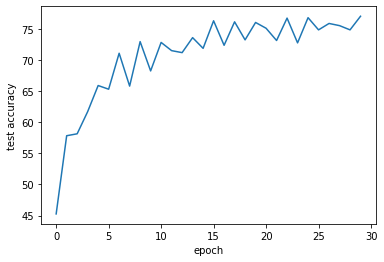

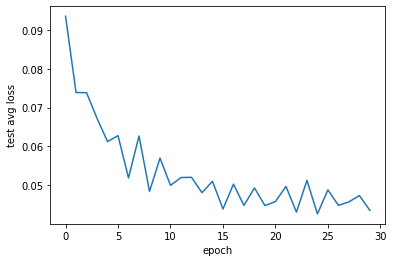

In [56]:
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.plot(list(range(len(accuracy))), accuracy)

plt.figure()
plt.xlabel('epoch')
plt.ylabel('test avg loss')
plt.plot(list(range(len(avg_loss))), avg_loss)
plt.show()

In [57]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == y).squeeze()
        for i in range(4):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
         classes[i], 100 * class_correct[i] / class_total[i]))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49d1c61710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49d1c61710>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Accuracy of plane : 80 %
Accuracy of   car : 90 %
Accuracy of  bird : 69 %
Accuracy of   cat : 51 %
Accuracy of  deer : 72 %
Accuracy of   dog : 69 %
Accuracy of  frog : 80 %
Accuracy of horse : 74 %
Accuracy of  ship : 89 %
Accuracy of truck : 82 %
